In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from models.HFR import HFRRes3D
from metrics.metrics import mse_dimwise, nrmse_dimwise, compute_valid_prediction_time, compute_attractor_deviation, compute_relative_psd, compute_psd
import json
import itertools
from tqdm import tqdm

In [3]:
def lorenz_deriv(state, t, sigma=10.0, rho=28.0, beta=8.0/3.0):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x*(rho - z) - y
    dzdt = x*y - beta*z
    return [dxdt, dydt, dzdt]

def generate_lorenz_data(
    initial_state=[1.0, 1.0, 1.0],
    tmax=25.0,
    dt=0.01,
    sigma=10.0,
    rho=28.0,
    beta=8.0/3.0
):
    num_steps = int(tmax / dt) + 1 # +1 to include t=0
    t_vals = np.linspace(0, tmax, num_steps)
    sol = odeint(lorenz_deriv, initial_state, t_vals, args=(sigma, rho, beta))
    return t_vals, sol

In [4]:
def report_vpt(name, preds, test_target, time_test, dt):
    T_VPT, T_lambda, ratio = compute_valid_prediction_time(
        test_target, preds, time_test, threshold=0.4, lambda_max=0.9, dt=dt
    )
    # print(f"{name:20s} => T_VPT={T_VPT:.3f},  T_lambda={T_lambda:.3f}, ratio={ratio:.3f}")
    return T_VPT, T_lambda, ratio

In [5]:
# 1) Generate Lorenz data
tmax = 250
dt   = 0.02
t_vals, lorenz_traj = generate_lorenz_data(
    initial_state=[1.0,1.0,1.0],
    tmax=tmax,
    dt=dt
)

washout = 2000
t_vals = t_vals[washout:]
lorenz_traj = lorenz_traj[washout:]

# normalize
scaler = StandardScaler()
scaler.fit(lorenz_traj)
lorenz_traj = scaler.transform(lorenz_traj)

T_data = len(lorenz_traj)
print(f"Data length: {T_data}, from t=0..{tmax} with dt={dt}.")

n_test_steps = 2100

# train/test split
train_frac = 0.8
train_end = int(train_frac*(T_data-1))
train_input  = lorenz_traj[:train_end]
train_target = lorenz_traj[1:train_end+1]
test_input   = lorenz_traj[train_end:train_end+n_test_steps]
test_target  = lorenz_traj[train_end+1:train_end+n_test_steps+1]
print(f"Train size: {len(train_input)}  Test size: {len(test_input)}")

initial_in = test_input[0]

Data length: 10501, from t=0..250 with dt=0.02.
Train size: 8400  Test size: 2100


In [6]:
# (g) Hierarchical Fractal Reservoir (HFR)
hfr_res = HFRRes3D(
    n_levels=3,
    cells_per_level=[5, 10, 20, 30, 35, 50, 60, 90],
    spectral_radius=0.94,
    input_scale=0.2,
    leaking_rate=0.6,
    ridge_alpha=1.00E-07,
    seed=50
)
hfr_res.fit_readout(train_input, train_target, discard=100)

hfr_preds = hfr_res.predict_autoregressive(initial_in, n_test_steps)

In [7]:
mse_hfr    = mse_dimwise(hfr_preds,    test_target)
nrmse_hfr    = nrmse_dimwise(hfr_preds,    test_target)
print(report_vpt("HFR",         hfr_preds, test_target, t_vals[train_end:train_end+n_test_steps], dt))
adev_hfr = compute_attractor_deviation(hfr_preds, test_target)
rel_psd_hfr = compute_relative_psd(test_target, hfr_preds, dt=dt)
print("PSD          :",  rel_psd_hfr)
print("ADev          :",  adev_hfr)
print("mse      :",  mse_hfr)
print("nrmse    :",  nrmse_hfr)


--- Valid Prediction Time (VPT) with threshold=0.4, lambda_max=0.9 ---
(np.float64(11.980000000000018), 1.1111111111111112, np.float64(10.782000000000016))
PSD          : 1.0416692779004124
ADev          : 1156
mse      : 2.7649311152914025
nrmse    : 2.1521680485291586


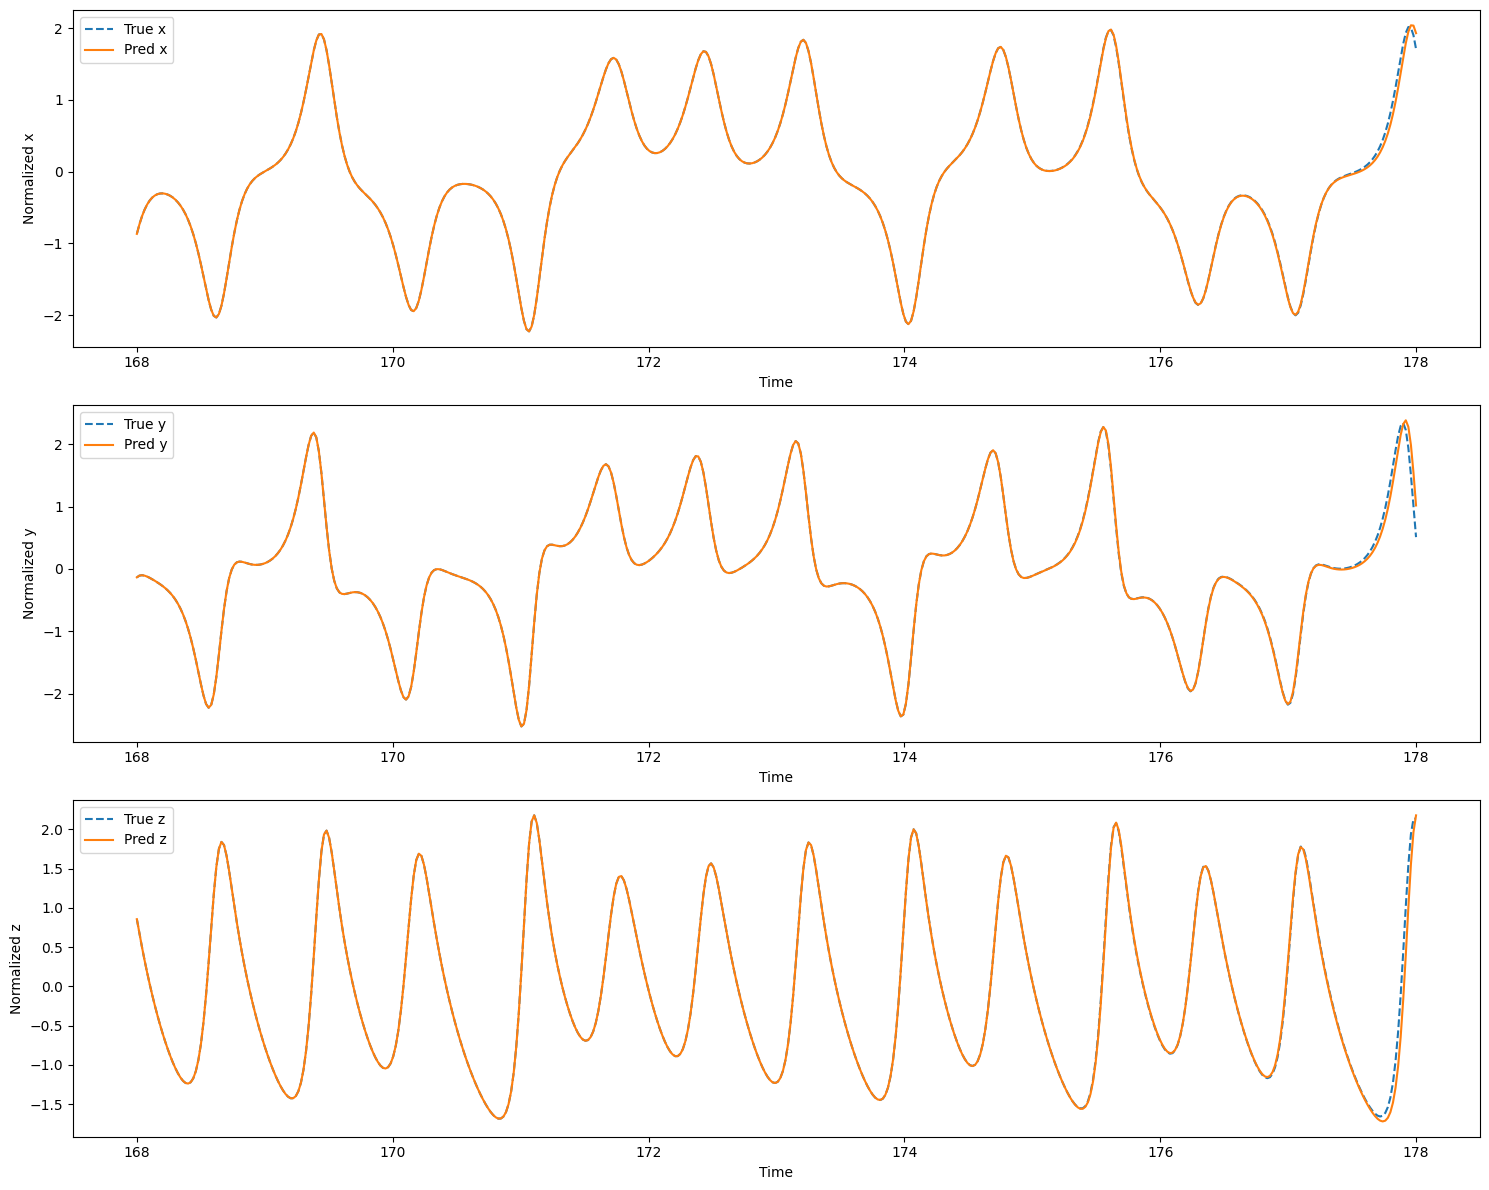

In [8]:
# 4) partial trajectory
plot_len = min(500, n_test_steps)
time_test = np.linspace(train_end*dt, (train_end+plot_len)*dt, plot_len)

plt.figure(figsize=(15, 12))

# Plot x
plt.subplot(3, 1, 1)
plt.plot(time_test, test_target[:plot_len, 0], label='True x', linestyle='--')
plt.plot(time_test, hfr_preds[:plot_len, 0], label='Pred x', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Normalized x')
plt.legend()

# Plot y
plt.subplot(3, 1, 2)
plt.plot(time_test, test_target[:plot_len, 1], label='True y', linestyle='--')
plt.plot(time_test, hfr_preds[:plot_len, 1], label='Pred y', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Normalized y')
plt.legend()

# Plot z
plt.subplot(3, 1, 3)
plt.plot(time_test, test_target[:plot_len, 2], label='True z', linestyle='--')
plt.plot(time_test, hfr_preds[:plot_len, 2], label='Pred z', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Normalized z')
plt.legend()

plt.tight_layout()
plt.show()


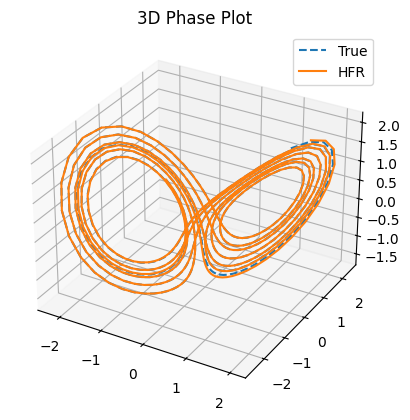

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(test_target[:plot_len,0], test_target[:plot_len,1], test_target[:plot_len,2], label='True', linestyle='--')
ax.plot(hfr_preds[:plot_len,0], hfr_preds[:plot_len,1], hfr_preds[:plot_len,2], label='HFR')
ax.set_title('3D Phase Plot')
ax.legend()
plt.show()

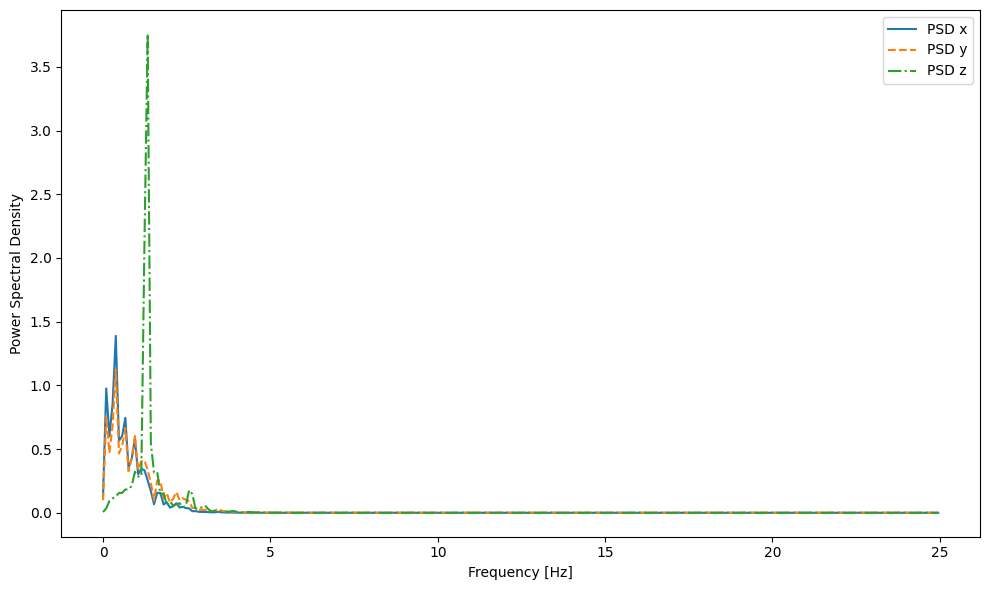

In [10]:
# Compute PSD (using your existing function)
freqs_z, psd_z, freqs_x, psd_x, freqs_y, psd_y = compute_psd(hfr_preds, dt=dt)

# Plot PSD vs. frequency for x, y and z
plt.figure(figsize=(10, 6))
plt.plot(freqs_x, psd_x, label='PSD x', linestyle='-')
plt.plot(freqs_y, psd_y, label='PSD y', linestyle='--')
plt.plot(freqs_z, psd_z, label='PSD z', linestyle='-.')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.tight_layout()
plt.show()